In [1]:
# Required packages to run the script
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticke
import seaborn as sns

from matplotlib.colors import LogNorm
import math
import os
import pickle as pkl
from scipy import sparse
from scipy.sparse.linalg import lsqr
import scipy.fftpack
import xlsxwriter
import importlib
import plotly.express as px
import plotly.graph_objects as go
import glob

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
import os

In [2]:
path_input_data = '../input_time_series/'
dpd = 24 # data per day in the time serie
dpy = 365 # data per year :  cut the leap years to 365 years

ndpd = 64 # new data per day for hourly data (for the interpolation)
signal_length = ndpd * dpy

In [3]:
import seaborn as sn
list_lags = pd.read_csv("results/lags_world_diff_true.csv", index_col=0)

for country_name in list_lags.index :
    result_optim = pd.read_pickle(f'results/{country_name}/optimization_results.pickle')
    list_lags.loc[country_name,'share_wind'] = result_optim['E_wind']/(result_optim['E_wind']+result_optim['E_pv']+result_optim['E_dispatch'])
    list_lags.loc[country_name,'share_pv'] = result_optim['E_pv']/(result_optim['E_wind']+result_optim['E_pv']+result_optim['E_dispatch'])
    list_lags.loc[country_name,'share_dispatch'] = result_optim['E_dispatch']/(result_optim['E_wind']+result_optim['E_pv']+result_optim['E_dispatch'])
    list_lags.loc[country_name, 'cf_pv']=result_optim['E_pv']/(result_optim['pv_capacity']*8760)
    list_lags.loc[country_name, 'cf_wind'] = result_optim['E_wind']/(result_optim['wind_capacity']*8760)
    list_lags.loc[country_name, 'Pmin/Pmax PV'] = np.min(result_optim['optimized_pv'])/np.max(result_optim['optimized_pv'])
    list_lags.loc[country_name, 'Pmin/Pmax Wind'] = np.min(result_optim['optimized_wind'])/np.max(result_optim['optimized_wind'])
    list_lags.loc[country_name, 'Pmin/Pmax Load'] = np.min(result_optim['consumption'])/np.max(result_optim['consumption'])
    list_lags.loc[country_name, 'Max Diff Wind/D']= np.max(result_optim['consumption']-result_optim['optimized_wind'])
    list_lags.loc[country_name, 'Mean Diff Wind/D']= np.mean(result_optim['consumption']-result_optim['optimized_wind'])

In [4]:
dataset = list_lags

In [5]:
# Variance study
# verification du model
# var_echantillon = dataset['share_pv'].var()
# var_model = share_predict.var()
# # print(var_model/var_echantillon,model.score(X, y)) # Ok
# # 'if variance du modelalmost  equals to sample variance, model is validated')
# # On garde le model bivarié linéaire et on cherche les thermes pour Mass nulm et SCx nul
# # cf wind à zero
# dataset['Zero'] = np.zeros(dataset.shape[0])
# X_W = dataset[['Lag Wind Year', 'Lag PV Year', 'Lag PV Week', 'Lag Wind Week','Lag PV Day', 'Lag Wind Day', 'cf_pv', 'Zero']].to_numpy()
# share_predict_W = model.predict(X_W)
# var_du_cf_wind = share_predict_W.var()
# moy_du_cf_wind = share_predict_W.mean()
# # cf pv à zero
# X_PV = dataset[['Lag Wind Year', 'Lag PV Year', 'Lag PV Week', 'Lag Wind Week','Lag PV Day', 'Lag Wind Day', 'Zero', 'cf_wind']].to_numpy()
# share_predict_PV = model.predict(X_PV)
# var_du_PV = share_predict_PV.var()
# moy_du_PV = share_predict_PV.mean()
# # cf pv à zero
# X_WD = dataset[['Lag Wind Year', 'Lag PV Year', 'Lag PV Week', 'Lag Wind Week','Lag PV Day', 'Zero', 'cf_pv', 'cf_wind']].to_numpy()
# share_predict_WD = model.predict(X_WD)
# var_du_WD = share_predict_WD.var()
# moy_du_WD = share_predict_WD.mean()
# # cf pv à zero
# X_PVD = dataset[['Lag Wind Year', 'Lag PV Year', 'Lag PV Week', 'Lag Wind Week','Zero', 'Lag Wind Day', 'cf_pv', 'cf_wind']].to_numpy()
# share_predict_PVD = model.predict(X_PVD)
# var_du_PVD = share_predict_PVD.var()
# moy_du_PVD = share_predict_PVD.mean()
# # lag wind week à zero
# X_WW= dataset[['Lag Wind Year', 'Lag PV Year', 'Lag PV Week', 'Zero','Lag PV Day', 'Lag Wind Day', 'cf_pv', 'cf_wind']].to_numpy()
# share_predict_WW = model.predict(X_WW)
# var_du_WW = share_predict_WW.var()
# moy_du_WW = share_predict_WW.mean()
# # lag pv week à zero
# X_PVW = dataset[['Lag Wind Year', 'Lag PV Year', 'Zero', 'Lag Wind Week','Lag PV Day', 'Lag Wind Day', 'cf_pv', 'cf_wind']].to_numpy()
# share_predict_PVW = model.predict(X_PVW)
# var_du_PVW = share_predict_PVW.var()
# moy_du_PVW = share_predict_PVW.mean()
# # lag pv year à zero
# X_PVY= dataset[['Lag Wind Year', 'Zero', 'Lag PV Week', 'Lag Wind Week','Lag PV Day', 'Lag Wind Day', 'cf_pv', 'cf_wind']].to_numpy()
# share_predict_PVY = model.predict(X_PVY)
# var_du_PVY = share_predict_PVY.var()
# moy_du_PVY = share_predict_PVY.mean()
# # lag wind year à zero
# X_WY = dataset[['Zero', 'Lag PV Year', 'Zero', 'Lag Wind Week','Lag PV Day', 'Lag Wind Day', 'cf_pv', 'cf_wind']].to_numpy()
# share_predict_WY = model.predict(X_WY)
# var_du_WY = share_predict_WY.var()
# moy_du_WY = share_predict_WY.mean()

# # calcul du terme constant, on met a zero la masse et le SCx
# X_zero = dataset[['Zero', 'Zero','Zero', 'Zero','Zero', 'Zero','Zero', 'Zero']].to_numpy()
# share_predict_zero = model.predict(X_zero)
# var_du_a_zero = share_predict_zero.var()  # doit valoir 0
# moy_du_a_zero = share_predict_zero.mean()
# moy_du_cf_wind -= moy_du_a_zero
# moy_du_PV -= moy_du_a_zero
# moy_du_WD -= moy_du_a_zero
# moy_du_WY -= moy_du_a_zero
# moy_du_PVY -= moy_du_a_zero
# moy_du_PVW -= moy_du_a_zero
# moy_du_WW -= moy_du_a_zero
# moy_du_PVD -= moy_du_a_zero

# mean_tot = share_predict.mean()
# assert(abs(moy_du_a_zero + moy_du_cf_wind + moy_du_PV+moy_du_WD+moy_du_WY+moy_du_PVW+moy_du_PVY+ moy_du_WW+moy_du_PVD- mean_tot) / mean_tot < 1e-10)
# labels = ['Mass<sub>EV</sub>', 'A.Cd<sub>EV</sub>', 'Corr<sub>(Mass,ACd)</sub>', 'Others']
# var_values = [var_du_cf_wind, var_du_PV, var_model - (var_du_cf_wind + var_du_PV),
#                 var_echantillon - var_model]
# mean_values = {'Constant': moy_du_a_zero, 'Mass<sub>EV</sub>': var_du_cf_wind, 'A.Cd<sub>EV</sub>': var_du_PV}
# # return {'measure conso': measured_conso, 'measure range': measured_range, 'data': dataset, 'model': model,
# #         'a': a, 'b_ACd': b_SCx, 'c_Mass': c_Mass, 'errors': df_error, 'mean': mean_values,
# #         'variance': dict(zip(labels, var_values))}


In [6]:
result_optim = pd.read_pickle(f'results/France/optimization_results.pickle')
result_optim.keys()

dict_keys(['optimized_pv', 'optimized_wind', 'optimized_dispatchable', 'optimized_stock', 'optimized_charge', 'optimized_discharge', 'optimized_p_curt', 'consumption', 'mean_consumption', 'pv_capacity', 'wind_capacity', 'dispatchable_capacity', 'E_wind', 'E_pv', 'E_dispatch', 'E_curt', 'E_loss', 'E_stock', 'E_destock', 'iso_alpha', 'cf_wind', 'cf_pv', 'capacity_factor_dispatch', 'share_dispatchable', 'share_wind', 'share_pv', 'num_loc'])

In [7]:
# On supprime les lignes des pays qui sont subdivisés en états
list_lags = list_lags.drop(['United States', 'China', 'Australia', 'Brazil', 'Russia', 'Canada', 'Antarctica'])
list_lags['State']=None
list_lags['Country']=list_lags.index     

In [8]:
list_lags_states = pd.read_csv("results/lags_world_diff_states_3.csv", index_col=1)
for state_name in list_lags_states.index :
    country_name = list_lags_states.loc[state_name, 'Country']
    if not type(country_name)==str: 
        country_name = country_name.iloc[0]
    result_optim = pd.read_pickle(f'results/{country_name}/optimization_results_{state_name}.pickle')
    list_lags_states.loc[state_name,'share_wind'] = result_optim['E_wind']/(result_optim['E_wind']+result_optim['E_pv']+result_optim['E_dispatch'])
    list_lags_states.loc[state_name,'share_pv'] = result_optim['E_pv']/(result_optim['E_wind']+result_optim['E_pv']+result_optim['E_dispatch'])
    list_lags_states.loc[state_name,'share_dispatch'] = result_optim['E_dispatch']/(result_optim['E_wind']+result_optim['E_pv']+result_optim['E_dispatch'])
    list_lags_states.loc[state_name, 'cf_pv']=result_optim['E_pv']/(result_optim['pv_capacity']*8760)
    list_lags_states.loc[state_name, 'cf_wind'] = result_optim['E_wind']/(result_optim['wind_capacity']*8760)
    list_lags_states.loc[state_name, 'Pmin/Pmax PV'] = np.min(result_optim['optimized_pv'])/np.max(result_optim['optimized_pv'])
    list_lags_states.loc[state_name, 'Pmin/Pmax Wind'] = np.min(result_optim['optimized_wind'])/np.max(result_optim['optimized_wind'])
    list_lags_states.loc[state_name, 'Pmin/Pmax Load'] = np.min(result_optim['consumption'])/np.max(result_optim['consumption'])
    list_lags_states.loc[state_name, 'Max Diff Wind/D']= np.max(result_optim['consumption']-result_optim['optimized_wind'])
    list_lags_states.loc[state_name, 'Mean Diff Wind/D']= np.mean(result_optim['consumption']-result_optim['optimized_wind'])

In [9]:
result = pd.concat([list_lags, list_lags_states])

In [10]:
result['Max Diff Wind/D'].isna().sum()


0

# Régression multiple

In [21]:
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
import os

dataset = result
X = dataset[[ 'Lag PV Year','Lag Wind Year', 'Lag PV Week', 'Lag Wind Week', 'Lag PV Day', 'Lag Wind Day','cf_pv', 'cf_wind']]
y = dataset['share_wind']

model = LinearRegression()
model.fit(X, y)
model.score(X, y)  # R²
print(model.score(X, y))
share_predict = model.predict(X)

coef = model.coef_
a = model.intercept_

dataset['Prediction share Wind'] = share_predict
# Model Evaluation
meanAbErr = metrics.mean_absolute_error(y, share_predict)
meanSqErr = metrics.mean_squared_error(y, share_predict)
rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y, share_predict))

print('Mean Absolute Error:', meanAbErr)
print('Mean Square Error:', meanSqErr)
print(f'Coefficient de détermination (R²): {model.score(X, y)}')

0.7215317208389387
Mean Absolute Error: 0.067006304404975
Mean Square Error: 0.0076277639269393275
Coefficient de détermination (R²): 0.7215317208389387


On ajoute maintenant les prédicteurs un par un pour voir l'évolution du R2.

In [13]:
dataset = result
X = dataset[['cf_wind']]
y = dataset['share_pv']

model = LinearRegression()
model.fit(X, y)
model.score(X, y)  # R²
print(model.score(X, y))
share_predict = model.predict(X)

coef = model.coef_
a = model.intercept_

dataset['Prediction share PV'] = share_predict
# Model Evaluation
meanAbErr = metrics.mean_absolute_error(y, share_predict)
meanSqErr = metrics.mean_squared_error(y, share_predict)
rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y, share_predict))

print('Mean Absolute Error:', meanAbErr)
print('Mean Square Error:', meanSqErr)
print(f'Coefficient de détermination (R²): {model.score(X, y)}')

0.2353449843499068
Mean Absolute Error: 0.11672661674120799
Mean Square Error: 0.020822924233545793
Coefficient de détermination (R²): 0.2353449843499068


# Analyse de la variance

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import f_regression


# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Initialisation du modèle de régression linéaire
model = LinearRegression()

# Entraînement du modèle
model.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluation des performances du modèle
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Analyse de la variance (ANOVA) dans le contexte de la régression linéaire
f_values, p_values = f_regression(X, y)

# Affichage des résultats
print("Coefficients estimés :", model.coef_)
print("Erreur quadratique moyenne (MSE) :", mse)
print("Coefficient de détermination (R^2) :", r2)
print("\nAnalyse de la variance (ANOVA) pour chaque paramètre (variables quantitatives) :")
for i, col in enumerate(X.columns):
    print(f"Paramètre {col}: F-value = {f_values[i]:.2f}, p-value = {p_values[i]:.2e}")


Coefficients estimés : [ 1.36496192e-06 -5.80864483e-06 -6.63173645e-05 -6.84529060e-05
 -1.69388672e-03 -1.72528165e-03 -2.73742215e+00  6.47540783e-01]
Erreur quadratique moyenne (MSE) : 0.01036954569774032
Coefficient de détermination (R^2) : 0.6236886307926195

Analyse de la variance (ANOVA) pour chaque paramètre (variables quantitatives) :
Paramètre Lag PV Year: F-value = 52.31, p-value = 3.24e-12
Paramètre Lag Wind Year: F-value = 86.36, p-value = 1.97e-18
Paramètre Lag PV Week: F-value = 0.31, p-value = 5.79e-01
Paramètre Lag Wind Week: F-value = 14.76, p-value = 1.46e-04
Paramètre Lag PV Day: F-value = 2.54, p-value = 1.12e-01
Paramètre Lag Wind Day: F-value = 13.67, p-value = 2.54e-04
Paramètre cf_pv: F-value = 212.56, p-value = 1.26e-37
Paramètre cf_wind: F-value = 132.80, p-value = 4.16e-26


# Random Forest

Erreur quadratique moyenne (MSE) : 0.006325739341561043
Coefficient de détermination (R^2) : 0.7704385802175918

Importance des variables :
Lag PV Year: Importance = 0.0483
Lag Wind Year: Importance = 0.0630
Lag PV Week: Importance = 0.0227
Lag Wind Week: Importance = 0.0280
Lag PV Day: Importance = 0.0356
Lag Wind Day: Importance = 0.0253
cf_pv: Importance = 0.5320
cf_wind: Importance = 0.2450


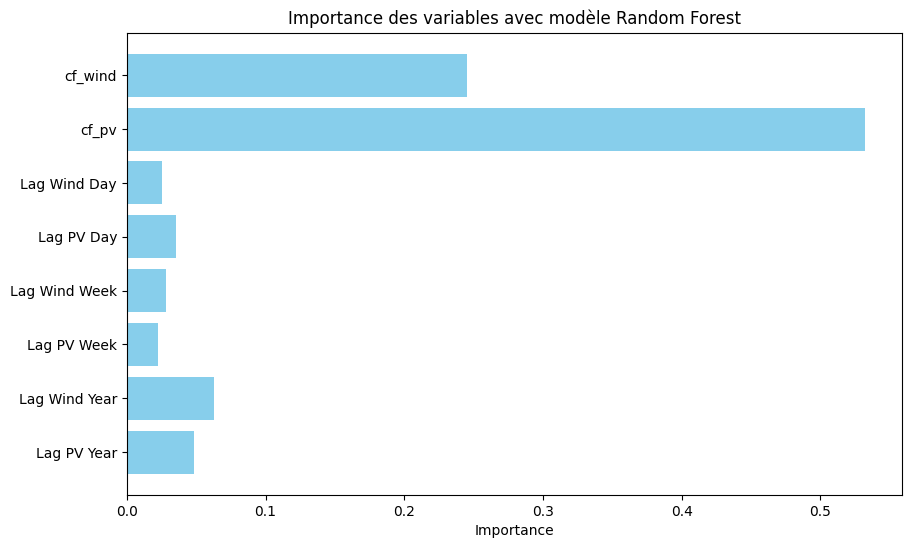

In [26]:
from sklearn.ensemble import RandomForestRegressor
# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Initialisation du modèle de forêt aléatoire
model = RandomForestRegressor(random_state=0)

# Entraînement du modèle
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

importances = model.feature_importances_

print("Erreur quadratique moyenne (MSE) :", mse)
print("Coefficient de détermination (R^2) :", r2)
print("\nImportance des variables :")
for i, col in enumerate(X.columns):
    print(f"{col}: Importance = {importances[i]:.4f}")


plt.figure(figsize=(10, 6))
plt.barh(X.columns, importances, color='skyblue')
plt.xlabel('Importance')
plt.title('Importance des variables avec modèle Random Forest')
plt.show()

Erreur quadratique moyenne (MSE) : 0.006325739341561043
Coefficient de détermination (R^2) : 0.7704385802175918

Importance des variables (permutation importance) :
Lag PV Year: Importance moyenne = 0.0250, Ecart-type = 0.0084
Lag Wind Year: Importance moyenne = 0.0338, Ecart-type = 0.0145
Lag PV Week: Importance moyenne = 0.0005, Ecart-type = 0.0051
Lag Wind Week: Importance moyenne = 0.0021, Ecart-type = 0.0030
Lag PV Day: Importance moyenne = 0.0220, Ecart-type = 0.0084
Lag Wind Day: Importance moyenne = 0.0061, Ecart-type = 0.0075
cf_pv: Importance moyenne = 0.6976, Ecart-type = 0.0974
cf_wind: Importance moyenne = 0.3313, Ecart-type = 0.0768


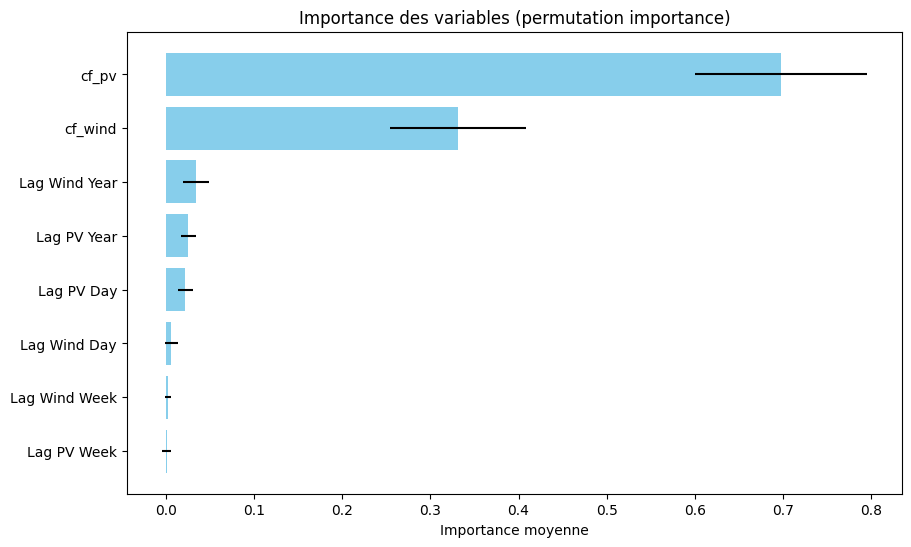

In [27]:
from sklearn.inspection import permutation_importance

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = RandomForestRegressor(random_state=0)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

result = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=0)

print("Erreur quadratique moyenne (MSE) :", mse)
print("Coefficient de détermination (R^2) :", r2)
print("\nImportance des variables (permutation importance) :")
for i, col in enumerate(X.columns):
    print(f"{col}: Importance moyenne = {result.importances_mean[i]:.4f}, Ecart-type = {result.importances_std[i]:.4f}")


sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(10, 6))
plt.barh(X.columns[sorted_idx], result.importances_mean[sorted_idx], xerr=result.importances_std[sorted_idx], color='skyblue')
plt.xlabel('Importance moyenne')
plt.title('Importance des variables (permutation importance)')
plt.show()